# Converting PyTorch to TensorFlow Lite for xCORE Using ONNX

ONNX is an open format built to represent machine learning models. We can convert from PyTorch to ONNX, then from ONNX to TensorFlow, then from TensorFlow to TensorFlow Lite, and finally, run it through xformer to optimise it for xCORE.

Ensure that you have installed Python 3.8 and have the installed requirements.txt

In [1]:
import sys
import os

# allow importing helper functions from local module
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Import PyTorch Model

For this example, we use YOLOv8.

In [2]:
import torch
from ultralytics import YOLO

pytorch_yolo = YOLO("yolov8n")

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:01<00:00, 5.75MB/s]


## Prepare Datasets

YOLO is trained on the COCO dataset. First lets download the images and their annotations.

In [3]:
!wget http://images.cocodataset.org/zips/val2017.zip -nc
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -nc

def unzip_dataset(path):
    import zipfile
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall("./coco")

import os
if not os.path.exists("./coco"):
    unzip_dataset("val2017.zip")
    unzip_dataset("annotations_trainval2017.zip")

File ‘val2017.zip’ already there; not retrieving.

File ‘annotations_trainval2017.zip’ already there; not retrieving.



Once we have downloaded and extracted the dataset, we can create generators which returns a tuple of [path, original image, original shape, Tensor of type BCHW]

In [122]:
from PIL import Image
import numpy
import json

def open_and_preprocess(path: str):
    size = pytorch_yolo.model.args["imgsz"]
    pil_img = Image.open(path).convert("RGB")
    resized_img = pil_img.resize((size, size))
    np_arr = numpy.array(resized_img).transpose([2, 0, 1])
    return (
        path,
        numpy.array(pil_img),
        numpy.array(pil_img).shape,
        torch.from_numpy(numpy.ascontiguousarray(numpy.expand_dims(np_arr, 0).astype(numpy.single) / 255))
    )

with open("./coco/annotations/instances_val2017.json") as fh:
    data = json.load(fh)
    images = data["images"]

    # generator that returns validation images as tuple [path, original image, original image shape, torch tensors of shape BCHW]
    def validation_images():
        for image in images:
            yield open_and_preprocess("coco/val2017/" + image["file_name"])

    class_names = {idx: cat["name"] for idx, cat in enumerate(data["categories"])}

## Perform an infrence on the pytorch model

Perform inference on the model to see how it works. The class you import when you run the imported "model" is not itself a pytorch model, it is a wrapper around it which applies some post-processing to the model output to put it into a nice `Results` object. Lets run both with and without the wrapper to see how to get the outputs into the `Results` class. 

In [137]:
# This is the same demo image we will use for all examples
demo_images = validation_images()
demo_image = next(demo_images)

# import ultralytics postprocessing classes
from ultralytics.utils.ops import non_max_suppression
from ultralytics.engine.results import Results

In [138]:
def display_result(results_obj: Results):
    im_array = results_obj.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image


image 1/1 /home/jovyan/work/pytorch_to_tflite/YOLOv8/coco/val2017/000000397133.jpg: 448x640 2 persons, 1 cup, 4 bowls, 1 potted plant, 1 oven, 70.2ms
Speed: 11.1ms preprocess, 70.2ms inference, 4.8ms postprocess per image at shape (1, 3, 448, 640)


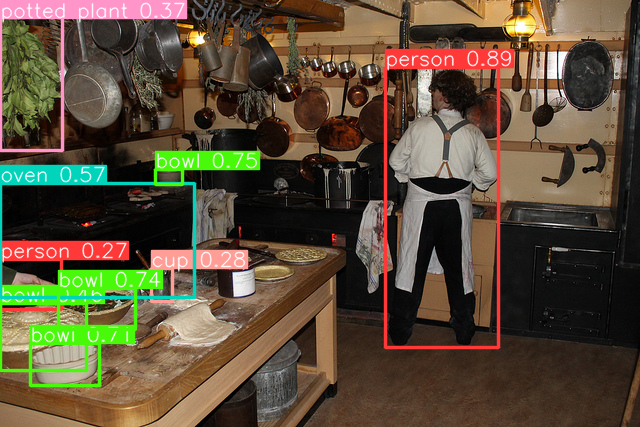

In [141]:
# using yolo wrapper
wrapper_results = pytorch_yolo(demo_image[0])
display_result(wrapper_results[0])

In [160]:
# using model directly
torch_tensor = demo_image[3]
pytorch_results = pytorch_yolo.model(torch_tensor)
res, _ = pytorch_results

# define function to put result through yolo post-processing
def post_process(result, image):
    preds = non_max_suppression(
        result,
        pytorch_yolo.predictor.args.conf,
        pytorch_yolo.predictor.args.iou,
        agnostic=pytorch_yolo.predictor.args.agnostic_nms,
        max_det=pytorch_yolo.predictor.args.max_det,
    )[0]
    return Results(
        orig_img = image[1],
        path = image[0],
        names = class_names, 
        boxes = preds
    )

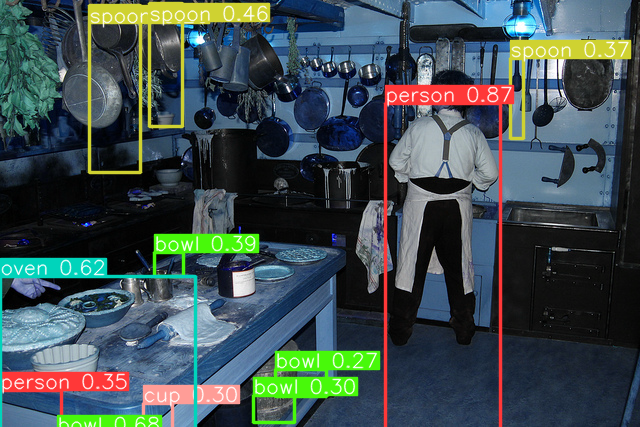

In [143]:
display_result(post_process(res, demo_image))

## Convert to ONNX


Pytorch has an onnx exporter included. It runs the model with the sample input and generates a trace of it. **For YOLO, which can normally accept a variety of input types (such as URLs, paths, PIL objects or numpy arrays), the converted model will only be able to accept the same type as the input**.

In [144]:
# This is only for shape info for tracing the model during conversion
sample_input = next(demo_images)[3]

onnx_model_path = "yolov8_v2.onnx"

torch.onnx.export(
    pytorch_yolo.model,
    sample_input,
    onnx_model_path,
    input_names=['images'],
    output_names = ['output0']
)

### Check ONNX Model

Check the onnx model with the check_model helper, then run the model with the same input as before to check that the results are similar.

In [146]:
import onnx
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)

### Convert ONNX to Keras

We do this using the `onnx2tf` package: https://github.com/PINTO0309/onnx2tf

**NB: onnx2tf will transpose your inputs to change BCHW into BHWC as is the TensorFlow convention.**

In [171]:
import onnx2tf

keras_model = onnx2tf.convert(
    input_onnx_file_path=onnx_model_path,
    output_folder_path="yolo_saved_model",
    copy_onnx_input_output_names_to_tflite=True,
    non_verbose=True,
    enable_rnn_unroll=True,
)

### Check the conversion to keras

In [172]:
# change to BHWC
tf_input_data = numpy.transpose(demo_image[3].numpy(), [0, 2, 3, 1])

keras_unprocessed_results = keras_model(tf_input_data)

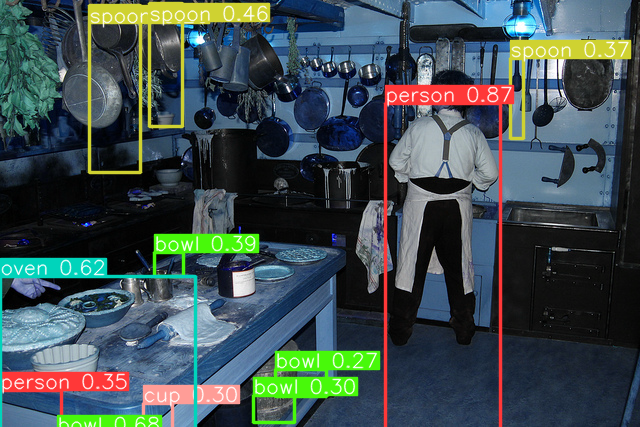

In [177]:
keras_processed_results = post_process(torch.from_numpy(keras_unprocessed_results.numpy()), demo_image)
display_result(keras_processed_results)

## Convert Keras to TFLite (int8)
We will still feed the data into the model in float32 format for convinence but the internals of the model will be int8. This will require representitive data but as we interface in float32 we can use the pytorch preprocessing. 

### Representative Dataset

To convert a model into to a TFLite flatbuffer, a representative dataset is required to help in quantisation. Refer to [Converting a keras model into an xcore optimised tflite model](https://colab.research.google.com/github/xmos/ai_tools/blob/develop/docs/notebooks/keras_to_xcore.ipynb) for more details on this.

In [19]:
import itertools

def representative_dataset():
    # in the interest of running the notebook fast, we only provide ten images;
    # ideally this would be done with a few hundred images.
    for image in itertools.islice(validation_images(), 10):
        # change to BHWC
        tf_batch = numpy.transpose(image[3].numpy(), [0, 2, 3, 1])
        yield [tf_batch]

### Run converter

In [20]:
# Now do the conversion to int8
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8 
# leave output as float32 so that we can use the YOLO post-processing functions
converter.inference_output_type = tf.float32

tflite_int8_model = converter.convert()


# Save the model.
tflite_int8_model_path = 'yolo.tflite'
with open(tflite_int8_model_path, 'wb') as f:
  f.write(tflite_int8_model)

fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: FLOAT32


### Check output
Lets use the same image as before to check that it gives us the same outputs

In [21]:
# convert intput to int8
tf_int_data = (tf_input_data*255 - 128).astype(numpy.int8)

In [178]:
tfl_interpreter = tf.lite.Interpreter(model_path=tflite_int8_model_path)
tfl_interpreter.allocate_tensors()

tfl_input_details = tfl_interpreter.get_input_details()
tfl_output_details = tfl_interpreter.get_output_details()

tfl_input_data = tf_int_data

tfl_interpreter.set_tensor(tfl_input_details[0]['index'], tfl_input_data)
tfl_interpreter.invoke()

tfl_output_data = tfl_interpreter.get_tensor(tfl_output_details[0]['index'])

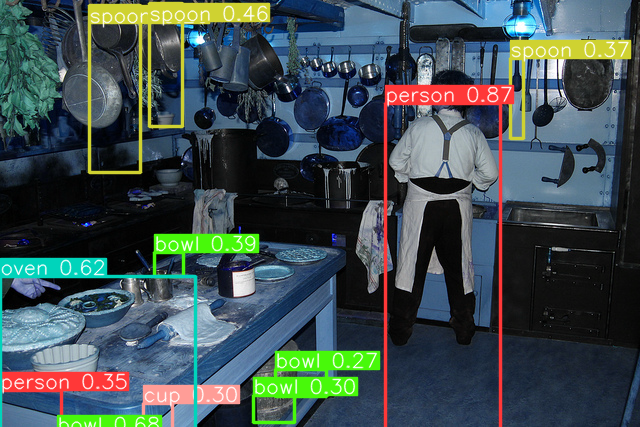

In [179]:
tfl_processed_results = post_process(torch.from_numpy(tfl_output_data), demo_image)
display_result(keras_processed_results)

tfl_preds = non_max_suppression(
    torch.from_numpy(tfl_output_data),
    pytorch_yolo.predictor.args.conf,
    pytorch_yolo.predictor.args.iou,
    agnostic=pytorch_yolo.predictor.args.agnostic_nms,
    max_det=pytorch_yolo.predictor.args.max_det,
    classes=pytorch_yolo.predictor.args.classes
)[0]
tfl_processed_results = Results(
    orig_img = demo_image[1],
    path = demo_image[0],
    names = demo_image[2],
    boxes=preds
)

# Analyse Models
Now the model is converted and we have confirmed that it works, let us take a look inside the converted models to see how good the conversion is.

## Check Operator Counts

Let us take a look at the operator counts inside the converted model. This uses a helper function defined in `../utils`, but this step is not necessary to convert the model.

In [25]:
import utils
utils.print_operator_counts(tflite_int8_model)

OPERATOR              COUNT
-------------------- ------
pad                       7
conv_2d                  64
logistic                 58
mul                      59
strided_slice            20
add                       8
concatenation            19
max_pool_2d               3
resize_nearest_neighbor      2
quantize                  2
transpose                 5
reshape                   5
softmax                   1
sub                       2
dequantize                1
-------------------- ------
TOTAL                   256
-------------------- ------
